In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

## Loading Data

In [3]:
df = pd.read_csv("alzheimers_disease_data.csv", index_col=0)

In [4]:
display(df.head())

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [5]:
# drop the column for doctor in charge
df = df.drop(df.columns[-1], axis=1)

In [6]:
df.shape
#edits

(2149, 33)

In [7]:
# Checking type of features
df.dtypes

Age                            int64
Gender                         int64
Ethnicity                      int64
EducationLevel                 int64
BMI                          float64
Smoking                        int64
AlcoholConsumption           float64
PhysicalActivity             float64
DietQuality                  float64
SleepQuality                 float64
FamilyHistoryAlzheimers        int64
CardiovascularDisease          int64
Diabetes                       int64
Depression                     int64
HeadInjury                     int64
Hypertension                   int64
SystolicBP                     int64
DiastolicBP                    int64
CholesterolTotal             float64
CholesterolLDL               float64
CholesterolHDL               float64
CholesterolTriglycerides     float64
MMSE                         float64
FunctionalAssessment         float64
MemoryComplaints               int64
BehavioralProblems             int64
ADL                          float64
C

In [8]:
# Check for null values
columns_with_null = df.columns[df.isnull().any()]
print("Columns with null values:", list(columns_with_null))

Columns with null values: []


In [9]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# import missingno as msno
# msno.matrix(df)
# plt.show()

# df.fillna(df.mean(), inplace=True)
# df.fillna(df.median(), inplace=True)  

Missing values in each column:
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

### Heatmap

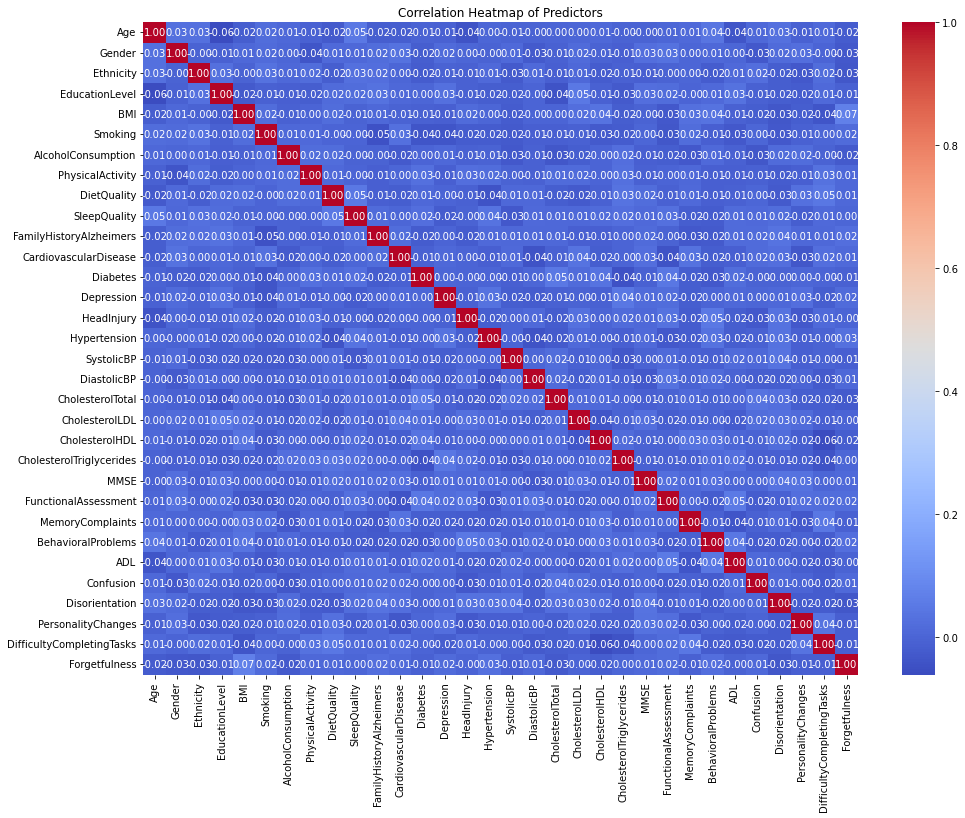

In [10]:
# Exclude target variable
predictors = df.drop(columns=['Diagnosis'])

# Compute correlation matrix
corr_matrix = predictors.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Predictors")
plt.savefig("heatmap.jpg")
plt.show()


In [11]:
# Scaling numerical features
from sklearn.preprocessing import StandardScaler

# Identifying numeric columns
# numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns  # This incorrectly select all columns including categorical
numeric_columns = list(df.select_dtypes('float64').columns) + ['Age', 'SystolicBP', 'DiastolicBP']
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

## Visualizing Correlations

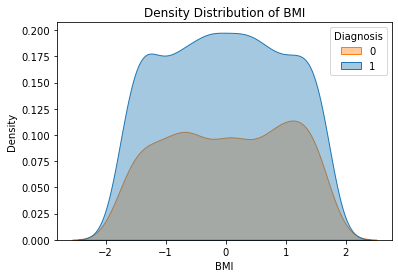

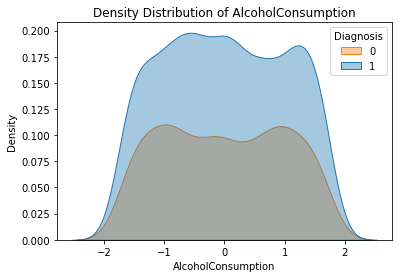

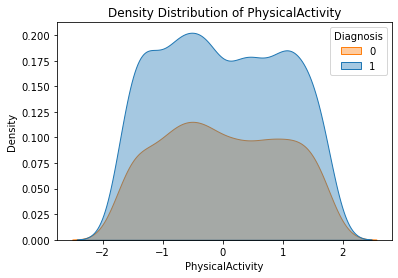

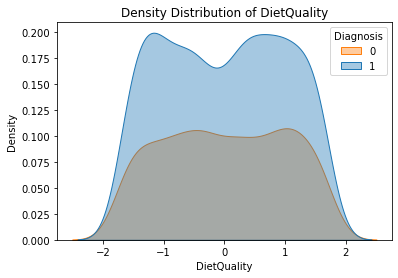

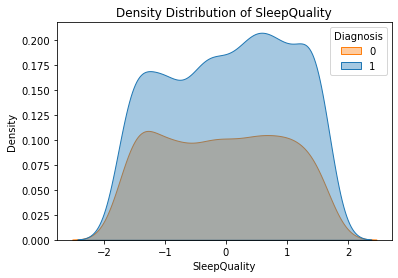

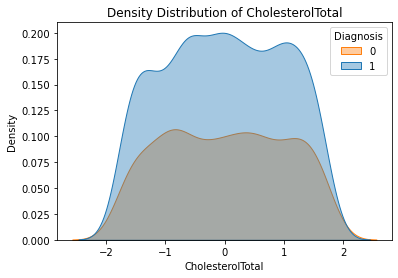

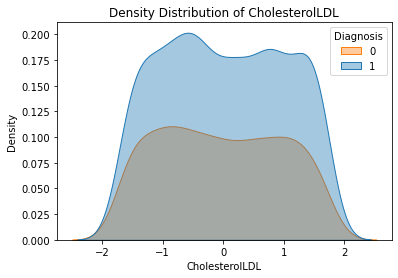

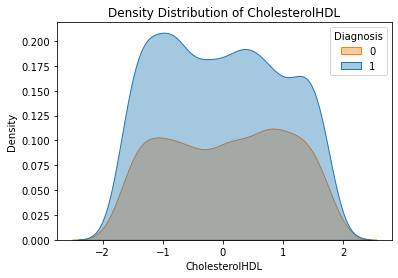

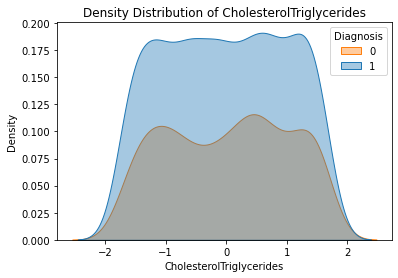

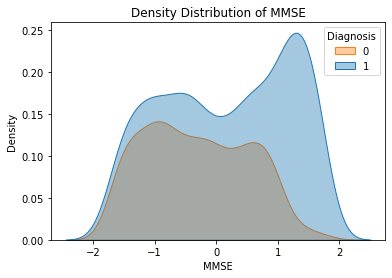

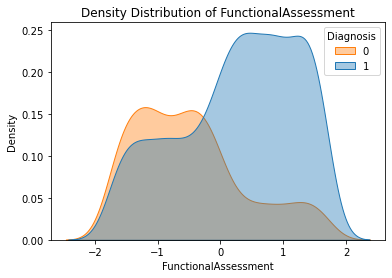

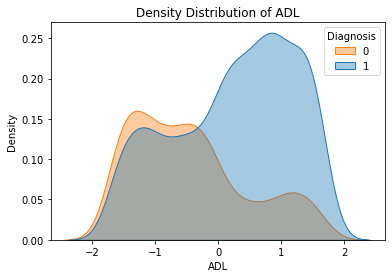

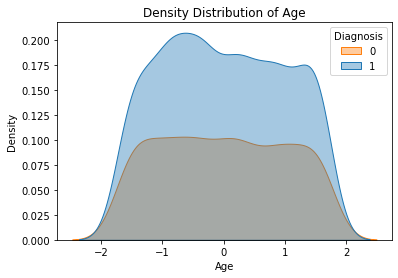

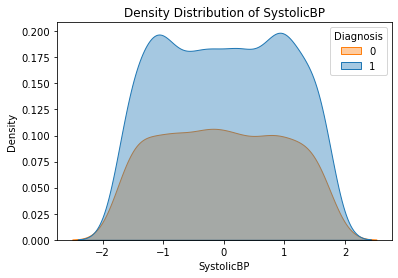

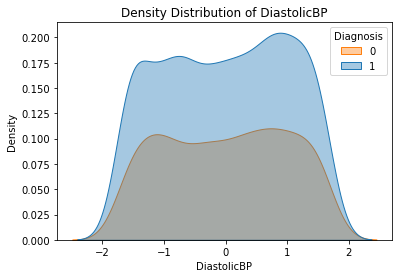

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot density distributions
for var in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=scaled_df, x=var, hue='Diagnosis', fill=True, alpha=0.4)
    plt.title(f"Density Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Density")
    plt.legend(title="Diagnosis", labels=['0', '1'])
    plt.show()


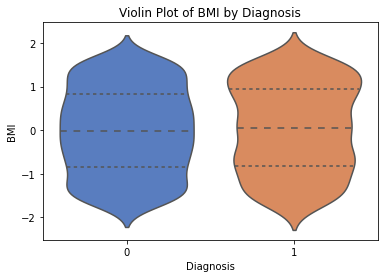

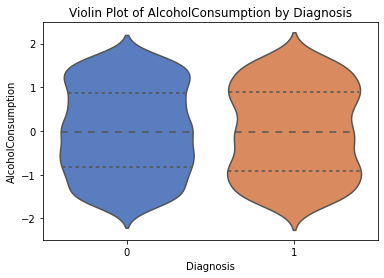

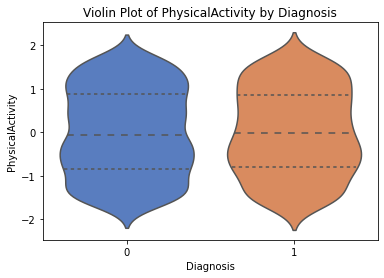

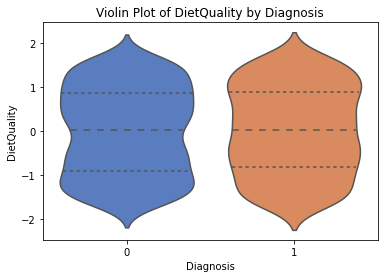

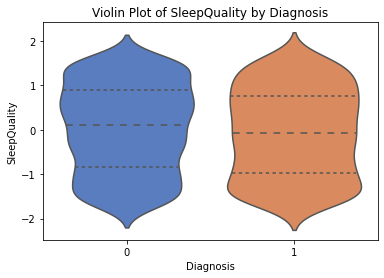

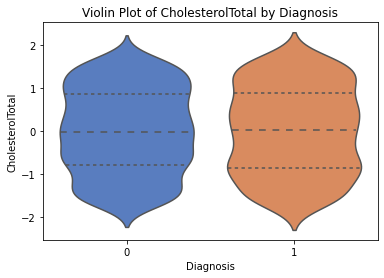

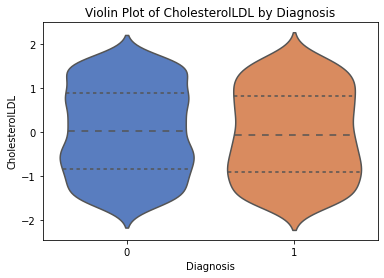

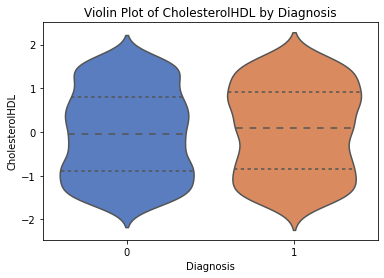

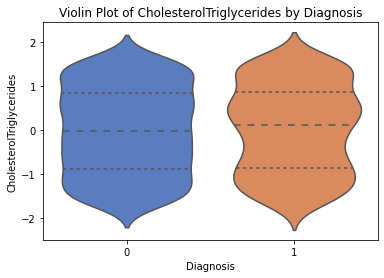

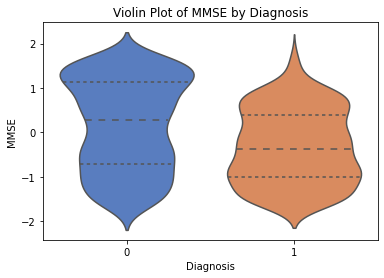

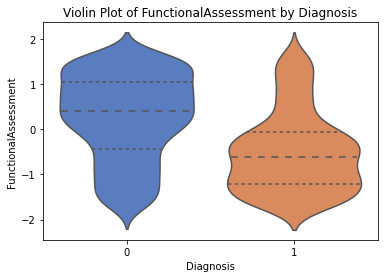

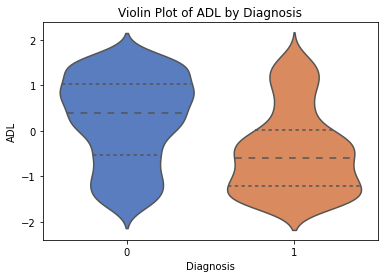

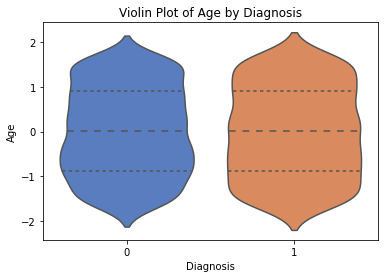

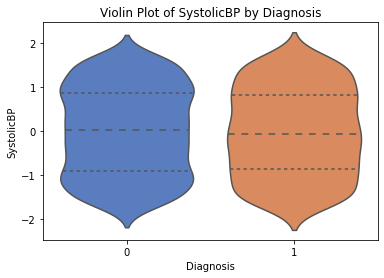

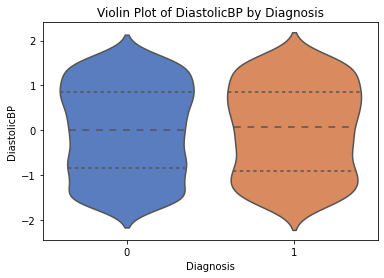

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through numeric columns to create side-by-side violin plots
for var in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=scaled_df, x='Diagnosis', y=var, inner='quartile', scale='width', palette='muted')
    plt.title(f"Violin Plot of {var} by Diagnosis")
    plt.xlabel("Diagnosis")
    plt.ylabel(var)
    plt.show()


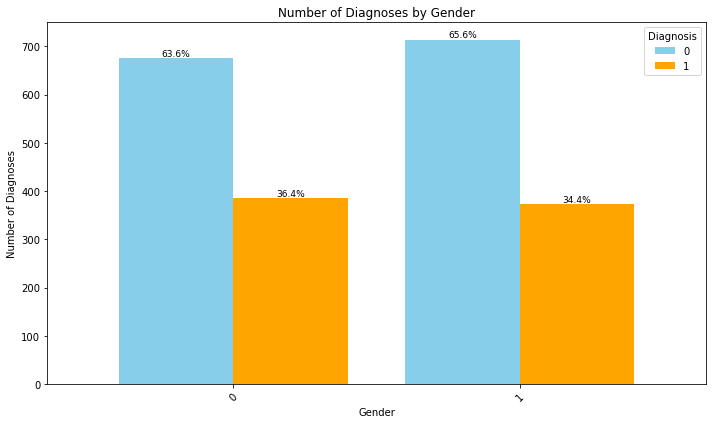

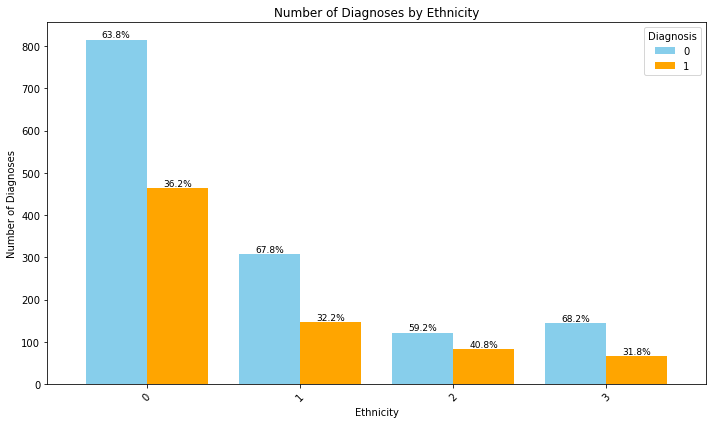

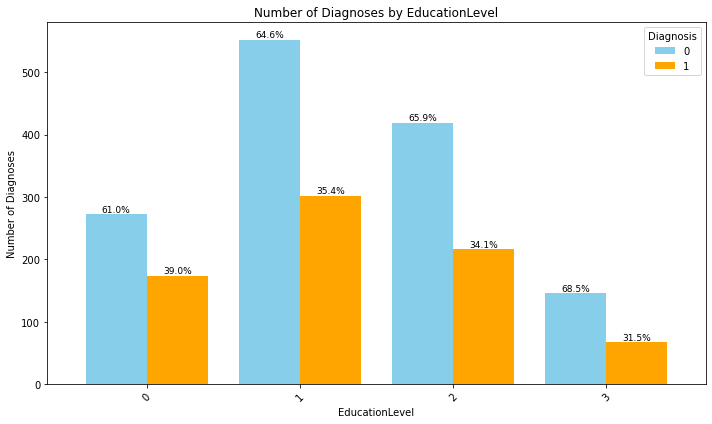

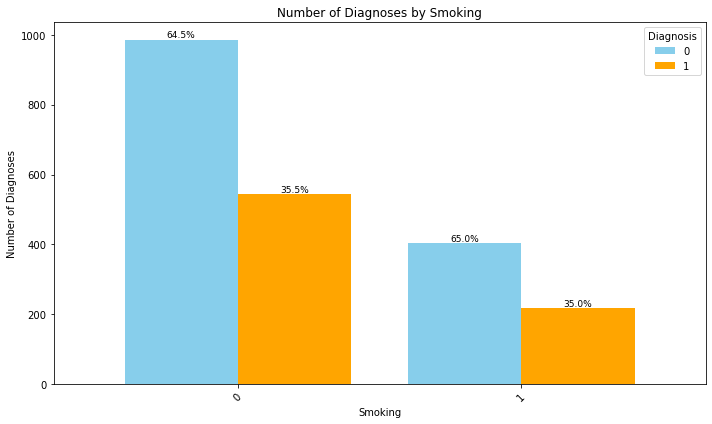

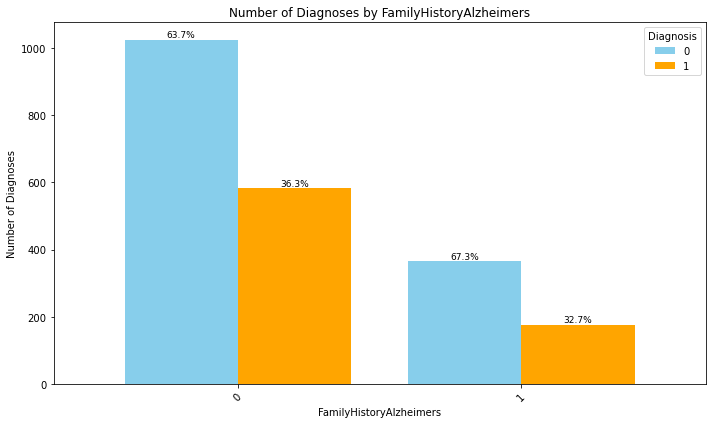

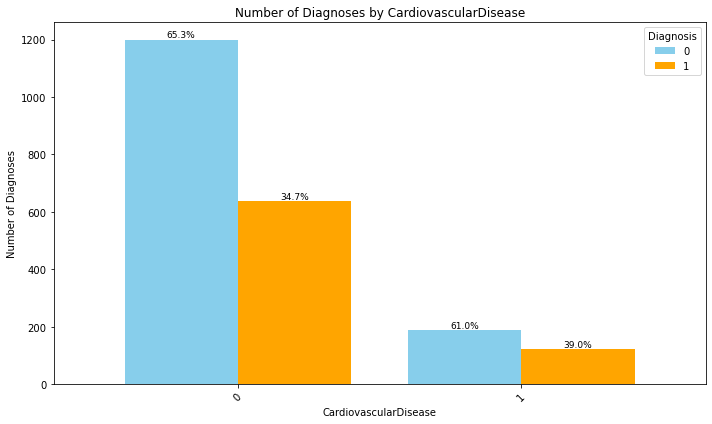

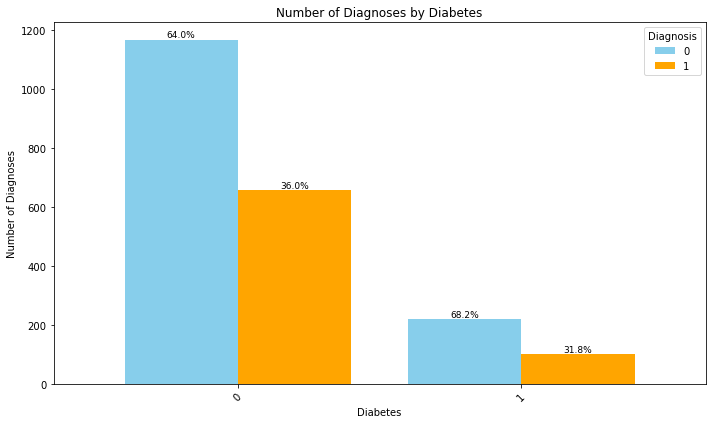

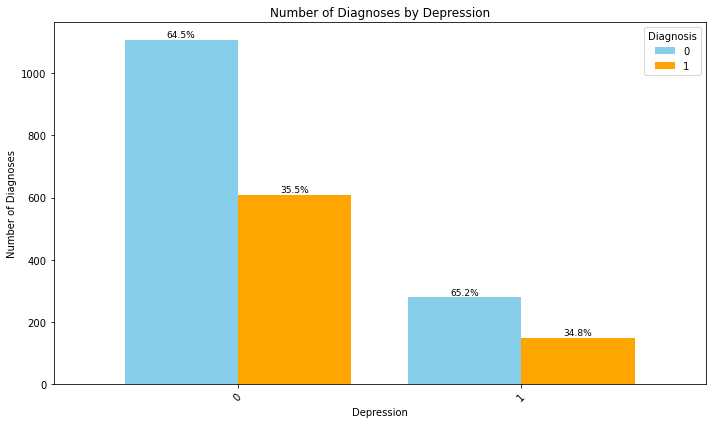

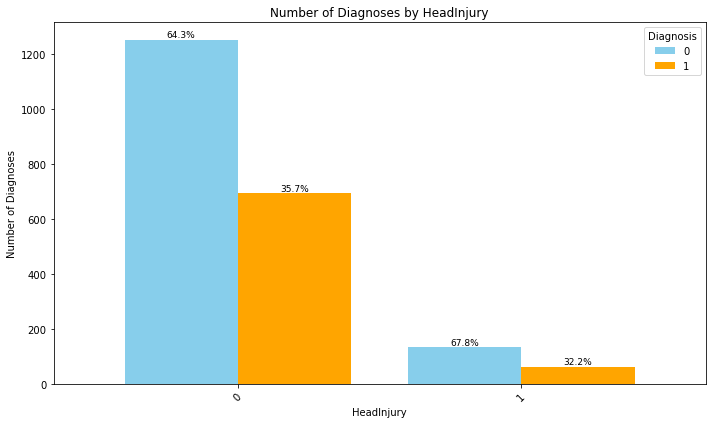

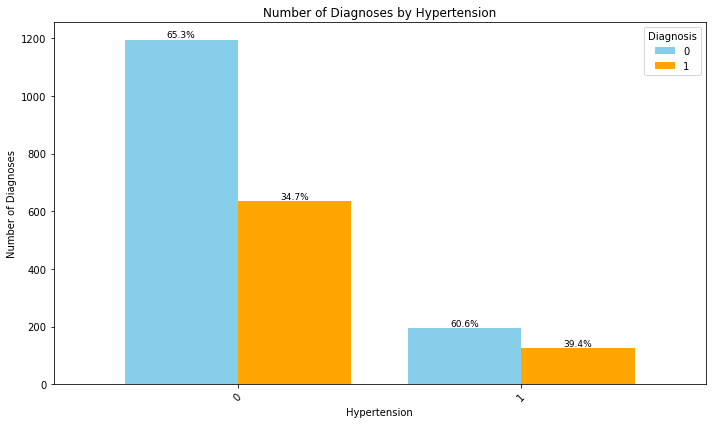

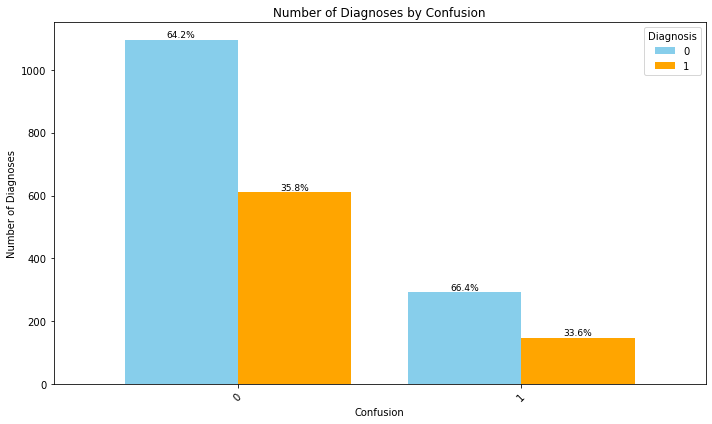

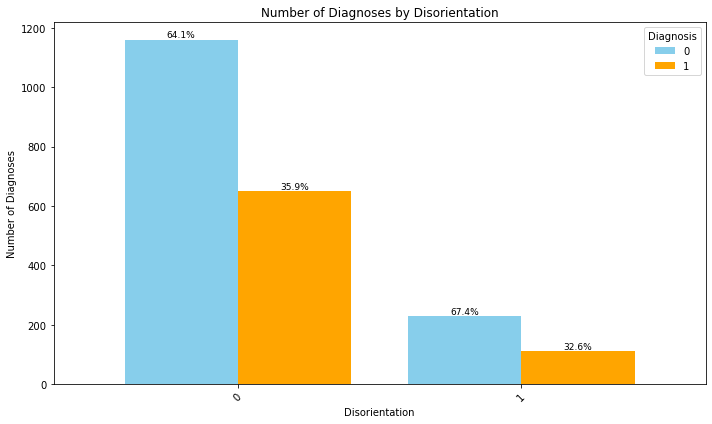

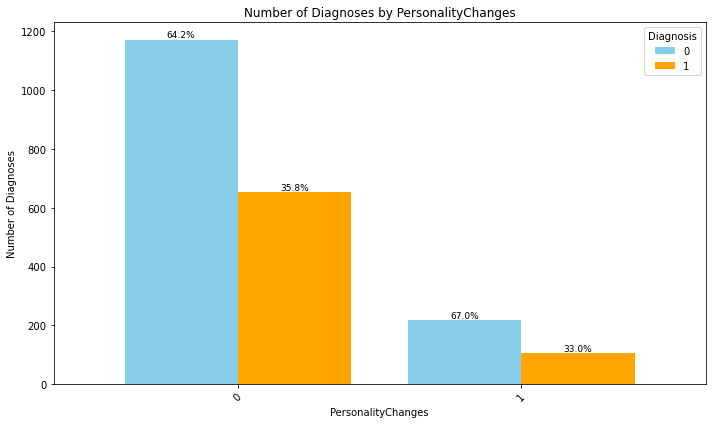

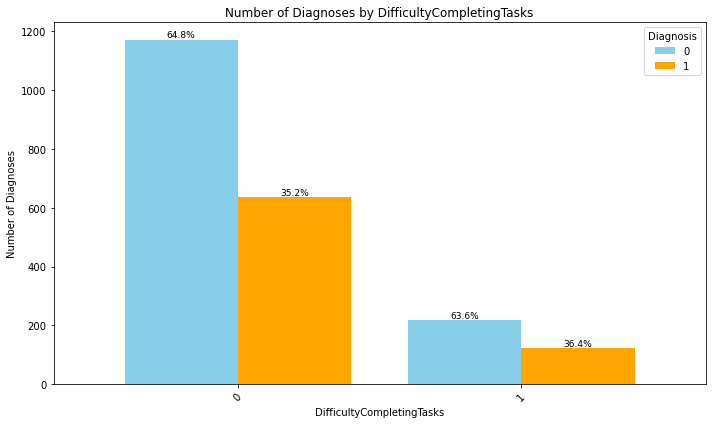

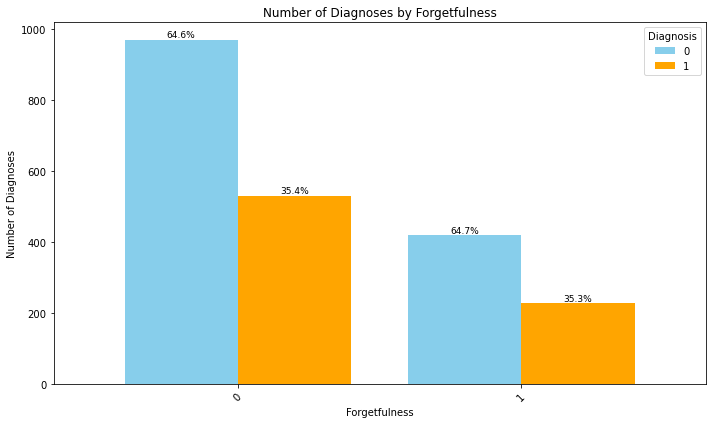

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# List of categorical variables
categorical_groups = [
    'Gender','Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers', 
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 
    'Hypertension', 'Confusion', 'Disorientation', 'PersonalityChanges', 
    'DifficultyCompletingTasks', 'Forgetfulness'
]

# Loop through each categorical variable to create bar plots with correct percentages
for cat_var in categorical_groups:
    # Group data by the categorical variable and Diagnosis
    grouped_data = df.groupby([cat_var, 'Diagnosis']).size().reset_index(name='Count')
    
    # Calculate total count for each level of the categorical variable
    total_counts = grouped_data.groupby(cat_var)['Count'].transform('sum')
    
    # Calculate the correct percentage for each Diagnosis level
    grouped_data['Percentage'] = (grouped_data['Count'] / total_counts) * 100
    
    # Pivot data for plotting counts and percentages
    pivot_counts = grouped_data.pivot(index=cat_var, columns='Diagnosis', values='Count').fillna(0)
    pivot_percentages = grouped_data.pivot(index=cat_var, columns='Diagnosis', values='Percentage').fillna(0)
    
    # Plot side-by-side bar chart
    ax = pivot_counts.plot(kind='bar', figsize=(10, 6), width=0.8, color=['skyblue', 'orange'])
    
    # Add percentages on the bars
    for bar_group, diagnosis in zip(ax.containers, pivot_percentages.columns):
        for bar, category in zip(bar_group, pivot_counts.index):
            height = bar.get_height()
            if height > 0:  # Only label bars with a positive height
                percentage = pivot_percentages.loc[category, diagnosis]
                ax.annotate(f'{percentage:.1f}%', 
                            (bar.get_x() + bar.get_width() / 2, height), 
                            ha='center', va='bottom', fontsize=9, color='black')
    
    # Customize plot
    plt.title(f'Number of Diagnoses by {cat_var}')
    plt.xlabel(cat_var)
    plt.ylabel('Number of Diagnoses')
    plt.xticks(rotation=45)
    plt.legend(title='Diagnosis', labels=['0', '1'])
    plt.tight_layout()
    
    # Show plot
    plt.show()



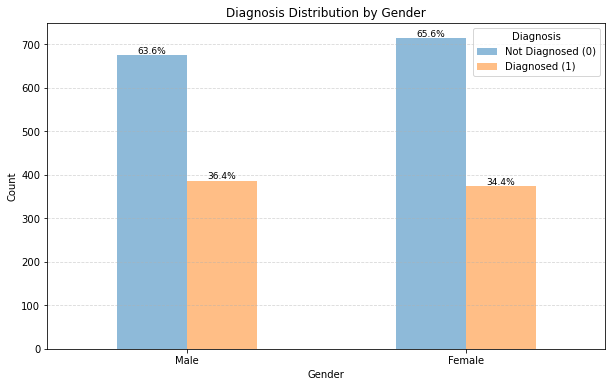

In [27]:
# Plot the count of diagnoses split by gender
gender_diagnosis_counts = df.groupby(['Gender', 'Diagnosis']).size().unstack(fill_value=0)
pivot_percentages = gender_diagnosis_counts.div(gender_diagnosis_counts.sum(axis=1), axis=0) * 100

ax = gender_diagnosis_counts.plot(kind='bar', figsize=(10, 6), alpha=0.5)

# Add percentages on the bars
for bars, diagnosis in zip(ax.containers, gender_diagnosis_counts.columns):
    for bar, gender in zip(bars, gender_diagnosis_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = pivot_percentages.loc[gender, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')

plt.title('Diagnosis Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
ax.set_xticklabels(gender_diagnosis_counts.index)
ax.set_xticklabels(['Male', 'Female'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

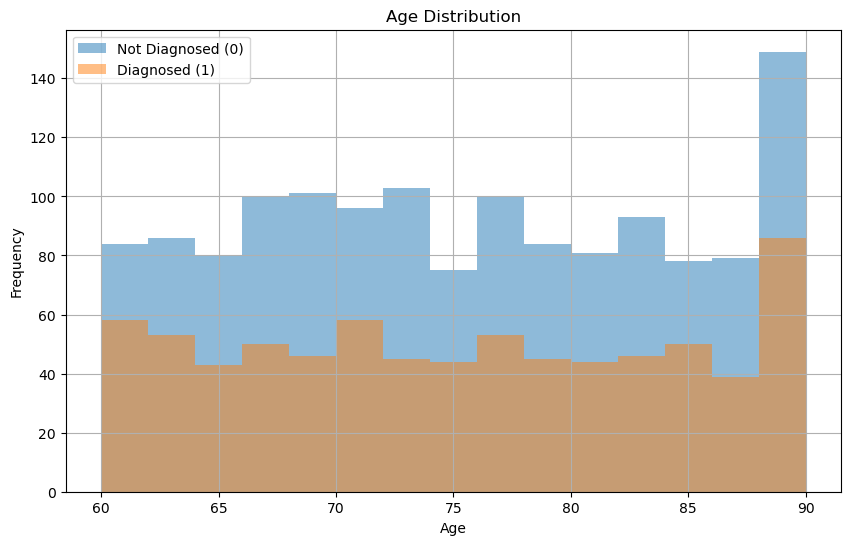

In [16]:
# Histograms for Age, split by Diagnosis
diagnosis_labels = {0: 'Not Diagnosed (0)', 1: 'Diagnosed (1)'}
plt.figure(figsize=(10, 6))
for diagnosis, group in df.groupby('Diagnosis'):
    plt.hist(group['Age'], bins=15, alpha=0.5, label=diagnosis_labels[diagnosis])

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

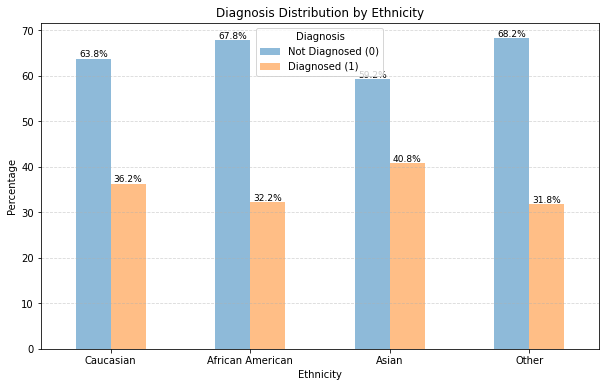

In [17]:
# Plot the ratio of diagnoses split by ethnicity
ethnicity_diagnosis_counts = df.groupby(['Ethnicity', 'Diagnosis']).size().unstack(fill_value=0)
ethnicity_diagnosis_ratio = ethnicity_diagnosis_counts.divide(ethnicity_diagnosis_counts.sum(axis=1), axis=0) * 100
ax = ethnicity_diagnosis_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)

for bars, diagnosis in zip(ax.containers, ethnicity_diagnosis_counts.columns):
    for bar, ethnicity in zip(bars, ethnicity_diagnosis_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = ethnicity_diagnosis_ratio.loc[ethnicity, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')

plt.title('Diagnosis Distribution by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
ax.set_xticklabels(['Caucasian', 'African American', 'Asian', 'Other'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

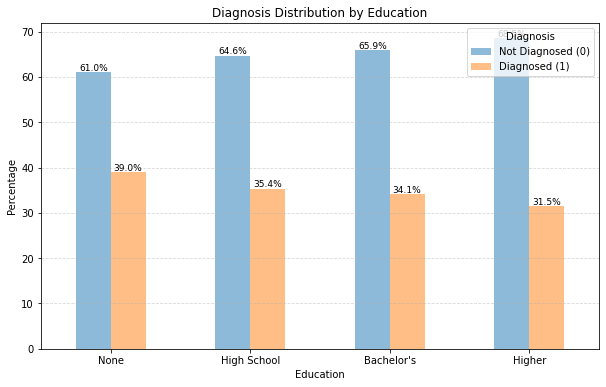

In [21]:
# Plot the ratio of diagnoses split by education
education_diagnosis_counts = df.groupby(['EducationLevel', 'Diagnosis']).size().unstack(fill_value=0)
education_diagnosis_ratio = ethnicity_diagnosis_counts.divide(ethnicity_diagnosis_counts.sum(axis=1), axis=0) * 100
ax = education_diagnosis_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)

for bars, diagnosis in zip(ax.containers, ethnicity_diagnosis_counts.columns):
    for bar, ethnicity in zip(bars, ethnicity_diagnosis_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = education_diagnosis_ratio.loc[ethnicity, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')

plt.title('Diagnosis Distribution by Education')
plt.xlabel('Education')
plt.ylabel('Percentage')
ax.set_xticklabels(['None', 'High School', 'Bachelor\'s', 'Higher'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

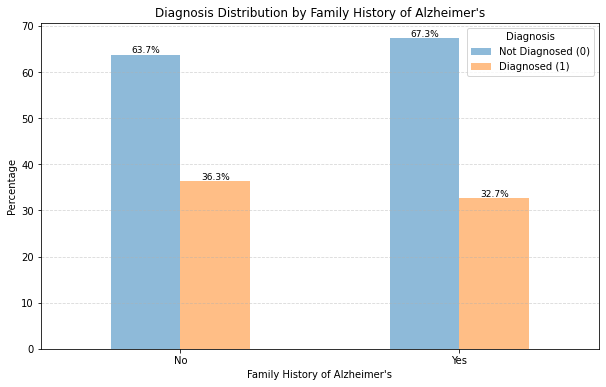

In [ ]:
# Plot the ratio of diagnoses split by family history
famhis_diagnosis_counts = df.groupby(['FamilyHistoryAlzheimers', 'Diagnosis']).size().unstack(fill_value=0)
famhis_diagnosis_ratio = famhis_diagnosis_counts.divide(famhis_diagnosis_counts.sum(axis=1), axis=0) * 100
ax = famhis_diagnosis_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)


for bars, diagnosis in zip(ax.containers, famhis_diagnosis_counts.columns):
    for bar, famhis in zip(bars, famhis_diagnosis_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = famhis_diagnosis_ratio.loc[famhis, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')
            
plt.title('Diagnosis Distribution by Family History of Alzheimer\'s')
plt.xlabel('Family History of Alzheimer\'s')
plt.ylabel('Percentage')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


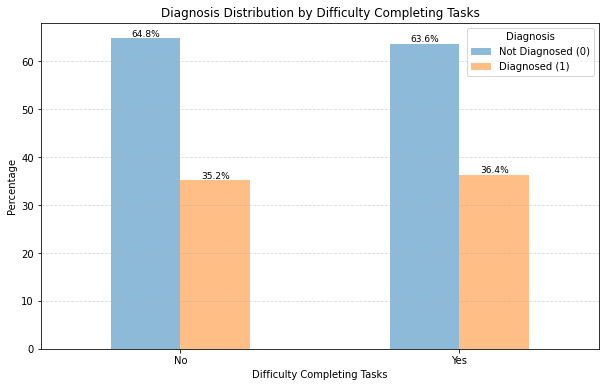

In [24]:
# Difficulty Completing Tasks
difficulty_counts = df.groupby(['DifficultyCompletingTasks', 'Diagnosis']).size().unstack(fill_value=0)
difficulty_ratio = difficulty_counts.divide(difficulty_counts.sum(axis=1), axis=0) * 100
ax = difficulty_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)


for bars, diagnosis in zip(ax.containers, difficulty_counts.columns):
    for bar, difficulty in zip(bars, difficulty_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = difficulty_ratio.loc[difficulty, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')


plt.title('Diagnosis Distribution by Difficulty Completing Tasks')
plt.xlabel('Difficulty Completing Tasks')
plt.ylabel('Percentage')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

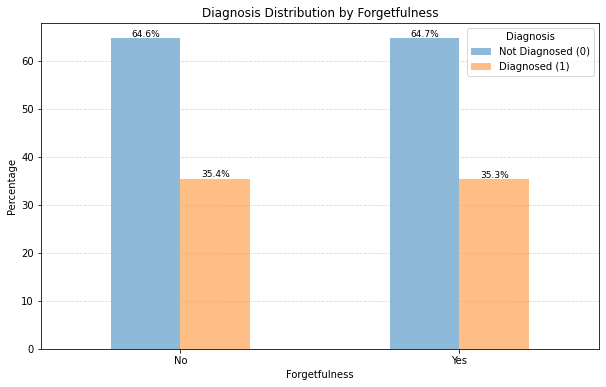

In [25]:
# Forgetfulness
forgetfulness_counts = df.groupby(['Forgetfulness', 'Diagnosis']).size().unstack(fill_value=0)
forgetfulness_ratio = forgetfulness_counts.divide(forgetfulness_counts.sum(axis=1), axis=0) * 100
ax = forgetfulness_ratio.plot(kind='bar', figsize=(10, 6), alpha=0.5)

for bars, diagnosis in zip(ax.containers, forgetfulness_counts.columns):
    for bar, forgetfulness in zip(bars, forgetfulness_counts.index):
        height = bar.get_height()
        if height > 0:  # Only label bars with a positive height
            percentage = forgetfulness_ratio.loc[forgetfulness, diagnosis]
            ax.annotate(f'{percentage:.1f}%', 
                        (bar.get_x() + bar.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=9, color='black')

plt.title('Diagnosis Distribution by Forgetfulness')
plt.xlabel('Forgetfulness')
plt.ylabel('Percentage')
ax.set_xticklabels(['No', 'Yes'])
plt.xticks(rotation=0)
plt.legend(title='Diagnosis', labels=['Not Diagnosed (0)', 'Diagnosed (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


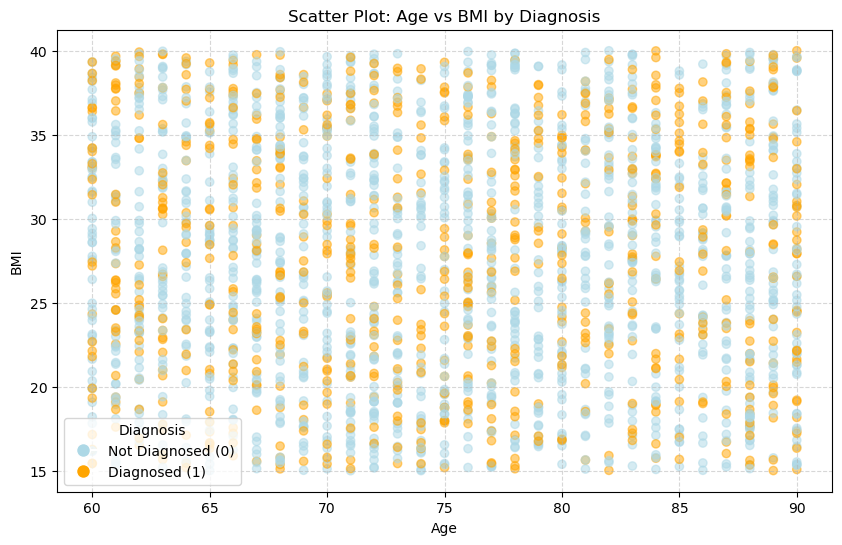

In [18]:
# Scatter plot for Age vs. BMI with Diagnosis as color
import matplotlib.lines as mlines

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df['Age'], 
    df['BMI'], 
    c=['lightblue' if diag == 0 else 'orange' for diag in df['Diagnosis']],
    alpha=0.5,
)

legend_labels = [mlines.Line2D([], [], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label='Not Diagnosed (0)'),
                 mlines.Line2D([], [], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Diagnosed (1)')]
plt.legend(handles=legend_labels, title='Diagnosis')

# Adding color bar and labels
plt.title('Scatter Plot: Age vs BMI by Diagnosis')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [20]:
# from scipy.stats import ttest_ind

# grouped_data = df.groupby('Ethnicity')

# # Age comparison between diagnosed and non-diagnosed groups
# diagnosed = grouped_data.get_group(1)['FunctionalAssessment']
# not_diagnosed = grouped_data.get_group(0)['FunctionalAssessment']

# t_stat, p_value = ttest_ind(diagnosed, not_diagnosed)
# print(f"T-test for FunctionalAssessment: T-statistic={t_stat:.2f}, P-value={p_value:.4f}")

T-tests and visualizations for correlation understanding

In [21]:
from scipy.stats import ttest_ind

# Separating the groups based on Diagnosis
diagnosed = df[df['Diagnosis'] == 1]
not_diagnosed = df[df['Diagnosis'] == 0]

# Initialize results dictionary
t_test_results = {}

# Perform T-tests for each numeric column
for col in numeric_columns:
    if col != 'Diagnosis':  # Exclude the target column
        t_stat, p_value = ttest_ind(diagnosed[col], not_diagnosed[col], nan_policy='omit')
        t_test_results[col] = {'T-statistic': t_stat, 'P-value': p_value}

# Display results
print("T-test Results:")
for col, stats in t_test_results.items():
    print(f"{col}: T-statistic = {stats['T-statistic']:.2f}, P-value = {stats['P-value']:.4f}")

T-test Results:
BMI: T-statistic = 1.22, P-value = 0.2222
AlcoholConsumption: T-statistic = -0.35, P-value = 0.7241
PhysicalActivity: T-statistic = 0.28, P-value = 0.7830
DietQuality: T-statistic = 0.39, P-value = 0.6935
SleepQuality: T-statistic = -2.62, P-value = 0.0087
CholesterolTotal: T-statistic = 0.30, P-value = 0.7670
CholesterolLDL: T-statistic = -1.48, P-value = 0.1384
CholesterolHDL: T-statistic = 1.97, P-value = 0.0484
CholesterolTriglycerides: T-statistic = 1.05, P-value = 0.2935
MMSE: T-statistic = -11.31, P-value = 0.0000
FunctionalAssessment: T-statistic = -18.16, P-value = 0.0000
ADL: T-statistic = -16.33, P-value = 0.0000
Age: T-statistic = -0.25, P-value = 0.7993
SystolicBP: T-statistic = -0.72, P-value = 0.4694
DiastolicBP: T-statistic = 0.25, P-value = 0.8063


Visualizing Significant Variable

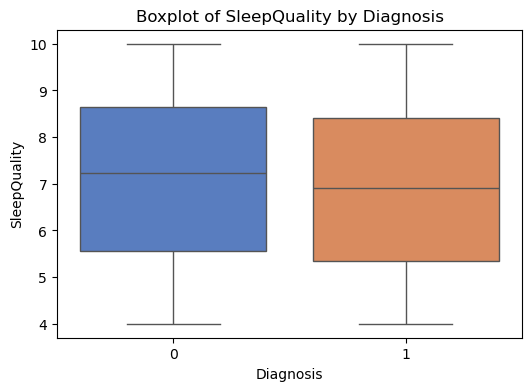

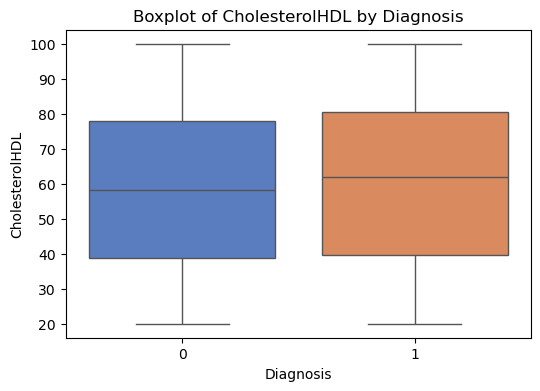

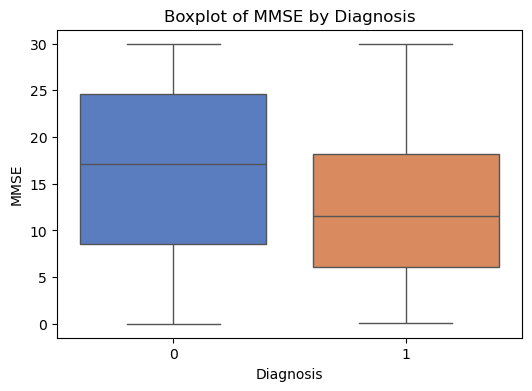

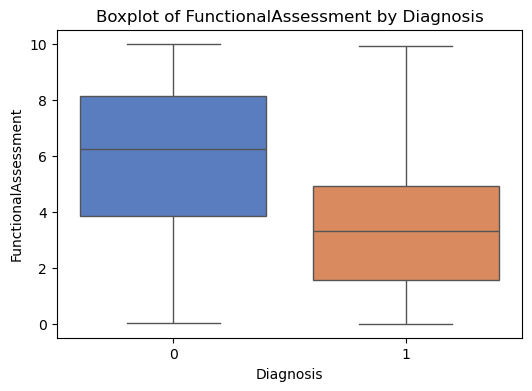

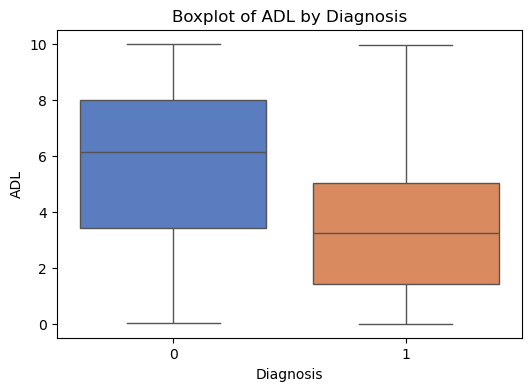

In [22]:
# Filtering significant variables
significant_vars = [col for col, stats in t_test_results.items() if stats['P-value'] < 0.05]

# Plot boxplots for significant variables
for col in significant_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Diagnosis', y=col, palette='muted')
    plt.title(f"Boxplot of {col} by Diagnosis")
    plt.xlabel("Diagnosis")
    plt.ylabel(col)
    plt.show()


In [23]:
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

# Print overall results
print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.74      0.74      0.74       152

    accuracy                           0.82       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       278
           1       0.84      0.86      0.85       152

    accuracy                           0.89       430
   macro avg       0.88      0.88      0.88       430
weighted avg       0.89      0.89      0.89       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       278
           1       0.94      0.89      0.92       152

    accuracy     

In [24]:
# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(-1.318723376086754, 'FunctionalAssessment'),
 (-1.2709133390638256, 'ADL'),
 (1.1372174158660078, 'MemoryComplaints'),
 (0.9280851834718691, 'BehavioralProblems'),
 (-0.8597950013014275, 'MMSE'),
 (0.1502186938932409, 'CholesterolHDL'),
 (-0.14995501583299645, 'CholesterolLDL')]

In [25]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(0.24320758656634994, 'MMSE'),
 (0.20109833662030716, 'ADL'),
 (0.18653250658505025, 'FunctionalAssessment'),
 (0.14148417484358478, 'MemoryComplaints'),
 (0.09892499202397032, 'BehavioralProblems'),
 (0.01732644673020464, 'DietQuality'),
 (0.016705887488411404, 'SleepQuality')]

We notice that the five Cognitive and Functional Assessment features contribute the most to our model, significantly surpassing all other features. This suggests that the final diagnosis may be directly derived from the results of these assessments.

## Applying Feature selection 
doing this after splitting to avoid data leakage

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define predictors (X) and target (y)
X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
y = scaled_df['Diagnosis']  # Target

# Feature Selection
# Select the top k features based on ANOVA F-value
k = 10  # Choose the number of features to retain (adjust based on experimentation)
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Check and convert target to discrete classes if necessary
print("Before processing, unique values in y:", y.unique())

# Example: Binarize continuous target (adjust the threshold as needed)
threshold = 0.5  # Modify based on your problem domain
if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
    y = (y > threshold).astype(int)

print("After processing, unique values in y:", y.unique())

# Proceed with feature selection and train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

Selected features: Index(['EducationLevel', 'SleepQuality', 'FamilyHistoryAlzheimers',
       'Hypertension', 'CholesterolHDL', 'MMSE', 'FunctionalAssessment',
       'MemoryComplaints', 'BehavioralProblems', 'ADL'],
      dtype='object')
Before processing, unique values in y: [0 1]
After processing, unique values in y: [0 1]


In [27]:
# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred) 
    results[model_name] = accuracy
    
    # Print classification report
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

print("Summary of Model Accuracies:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       278
           1       0.75      0.75      0.75       152

    accuracy                           0.82       430
   macro avg       0.81      0.81      0.81       430
weighted avg       0.82      0.82      0.82       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       278
           1       0.87      0.89      0.88       152

    accuracy                           0.92       430
   macro avg       0.91      0.91      0.91       430
weighted avg       0.92      0.92      0.92       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.90      0.92       152

    accuracy     

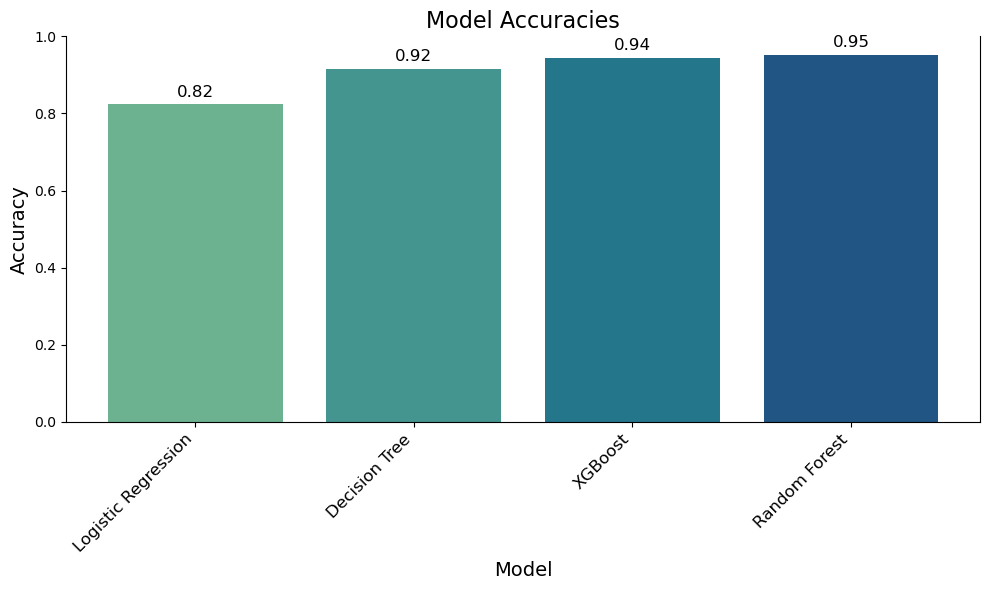

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for visualization
model_names = list(results.keys())
accuracies = list(results.values())

# Generate a Seaborn color palette
colors = sns.color_palette("crest", len(model_names))

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=colors)  # Use Seaborn colors
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
plt.title("Model Accuracies", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Add accuracy values on top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

# Remove the top line of the plot box
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)

# Show the plot
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.savefig("model_accuracies.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


# TODO: hyperparameter tuning - bingchengn and allie - DONE

After feature selection, the accuracy score for Random Forest is higher than XGBoost, unlike before feature selection.

>lr 0.844 (0.028)
>cart 0.906 (0.020)
>XGBoost 0.947 (0.013)
>rf 0.952 (0.012)
>stacking 0.951 (0.012)


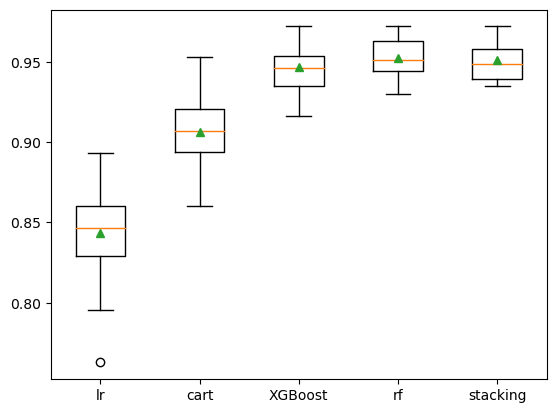

In [29]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn.feature_selection import SelectKBest, f_classif
 
# get the dataset
def get_dataset():
	X = scaled_df.drop(columns=['Diagnosis'])  # Predictors
	y = scaled_df['Diagnosis']  # Target
	k = 10
	selector = SelectKBest(score_func=f_classif, k=k)
	X_selected = selector.fit_transform(X, y)
	threshold = 0.5  # Modify based on your problem domain
	if y.dtypes in ['float64', 'float32']:  # Check if y is continuous
		y = (y > threshold).astype(int)
	return X_selected, y
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('XGBoost', XGBClassifier(eval_metric='logloss')))
	level0.append(('rf', RandomForestClassifier()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	stack_models = dict()
	stack_models['lr'] = LogisticRegression()
	stack_models['cart'] = DecisionTreeClassifier()
	stack_models['XGBoost'] = XGBClassifier(eval_metric='logloss')
	stack_models['rf'] = RandomForestClassifier()
	stack_models['stacking'] = get_stacking()
	return stack_models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X_selected, y = get_dataset()
# get the models to evaluate
stack_models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in stack_models.items():
	scores = evaluate_model(model, X_selected, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

rf performs almost the same as stacking

In [77]:
# Tunning hyperparameter for Logistic Regression Model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define dataset
X_selected, y = get_dataset()

# Define logistic regression model
lr_model = LogisticRegression(solver='liblinear')

# Define parameter grid for LR
lr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_selected, y)

print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_search_lr.best_score_)


Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy for Logistic Regression: 0.8440678701143817


In [78]:
# Tunning hyperparameter for Logistic Regression Model - Elastic Net
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define dataset
X_selected, y = get_dataset()

# Define logistic regression model
elastic_model = LogisticRegression(solver='saga', max_iter=500)

# Define parameter grid for LR
elastic_param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.2, 0.5, 0.8]
}

grid_search_elastic = GridSearchCV(estimator=elastic_model, param_grid=elastic_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_elastic.fit(X_selected, y)

print("Best parameters for Elastic Net:", grid_search_elastic.best_params_)
print("Best cross-validation accuracy for Elastic Net:", grid_search_elastic.best_score_)

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Best cross-validation accuracy for Elastic Net: 0.8445308180191902


In [79]:
# Tunning hyperparameter 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# define dataset
X_selected, y = get_dataset()

# Tune hyperparameters for XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5,
                               scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_selected, y)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation accuracy for XGBoost:", grid_search_xgb.best_score_)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best cross-validation accuracy for XGBoost: 0.9524714045644277


In [80]:
# Tune hyperparameters for Random Forest
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [150, 180, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [1, 2, 3, 5],
    'max_features': ['auto', 'sqrt']
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5,
                              scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_selected, y)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)


Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 250}
Best cross-validation accuracy for Random Forest: 0.9538678375887677


In [81]:
# Tune hyperparameters for StackingClassifier
# Define base estimators
level0 = [
    ('lr', LogisticRegression()),
    ('cart', DecisionTreeClassifier()),
    ('XGBoost', XGBClassifier(eval_metric='logloss')),
    ('rf', RandomForestClassifier())
]
# Define meta learner
level1 = LogisticRegression()

stacking_clf = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Define parameter grid
stacking_param_grid = {
    'final_estimator__C': [0.1, 1.0, 10.0],
    'XGBoost__n_estimators': [50, 100],
    'XGBoost__max_depth': [3, 5],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5],
    'cart__max_depth': [None, 5, 10]
}

grid_search_stacking = GridSearchCV(estimator=stacking_clf, param_grid=stacking_param_grid, cv=5,
                                    scoring='accuracy', n_jobs=-1)
grid_search_stacking.fit(X_selected, y)

print("Best parameters for StackingClassifier:", grid_search_stacking.best_params_)
print("Best cross-validation accuracy for StackingClassifier:", grid_search_stacking.best_score_)

Best parameters for StackingClassifier: {'XGBoost__max_depth': 3, 'XGBoost__n_estimators': 50, 'cart__max_depth': None, 'final_estimator__C': 10.0, 'rf__max_depth': None, 'rf__n_estimators': 100}
Best cross-validation accuracy for StackingClassifier: 0.9515433403805496


Predictions based on Feature Categories

In [35]:
# Define feature categories
categories = {
    "Demographic": ['EducationLevel', 'FamilyHistoryAlzheimers'],
    "Lifestyle": ['SleepQuality', 'MemoryComplaints'],
    "Medical": ['Hypertension', 'CholesterolHDL', 'BehavioralProblems'],
    "Cognitive": ['MMSE', 'FunctionalAssessment', 'ADL'],
    "No_Cognitive_or_Clinical": ['Hypertension', 'BehavioralProblems', 'EducationLevel',
                    'FamilyHistoryAlzheimers','SleepQuality', 'MemoryComplaints']
}

# Iterate through each category, subset the data, and run the models
results_by_category = {}

for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")
    
    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_category, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train and evaluate models
    results = {}
    for model_name, pipeline in models.items():
        pipeline.fit(X_train, y_train)  # Train the model
        y_pred = pipeline.predict(X_test)  # Predict on test data
        accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
        results[model_name] = accuracy

        # Print classification report
        print(f"Model: {model_name}")
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    
    # Store results for this category
    results_by_category[category] = results

# Print overall results for each category
print("Summary of Model Accuracies by Feature Category:")
for category, result in results_by_category.items():
    print(f"\n{category}:")
    for model, accuracy in result.items():
        print(f"{model}: {accuracy:.4f}")


### Predictions based on Demographic features ###
Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

--------------------------------------------------
Model: XGBoost
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.

# TODO: add remaining models for each category - allie - DONE

In [39]:
# Hyperparameter Tuning for Categories
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import warnings

warnings.filterwarnings('ignore')  # Suppress warnings for clean output

# Define hyperparameter grids
log_reg_param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear']
}

elastic_net_param_grid = {
    'C': [0.1, 1, 10], 
    'penalty': ['elasticnet'], 
    'l1_ratio': [0.2, 0.5, 0.8], 
    'solver': ['saga'],
    'max_iter': [500]
}

random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Results dictionary
results_by_category_tuning = {}

# Iterate through each category
for category, features in categories.items():
    print(f"\n### Predictions based on {category} features ###")

    # Subset the data
    X_category = scaled_df[features]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_category, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Results for this category
    results = {}
    
    # Logistic Regression
    log_reg = LogisticRegression()
    grid_search_log_reg = GridSearchCV(
        estimator=log_reg, param_grid=log_reg_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_log_reg.fit(X_train, y_train)
    y_pred = grid_search_log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Logistic Regression'] = {
        'accuracy': accuracy,
        'best_params': grid_search_log_reg.best_params_
    }
    print(f"Best parameters for Logistic Regression: {grid_search_log_reg.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Elastic Net
    elastic_net = LogisticRegression()
    grid_search_elastic_net = GridSearchCV(
        estimator=elastic_net, param_grid=elastic_net_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_elastic_net.fit(X_train, y_train)
    y_pred = grid_search_elastic_net.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Elastic Net'] = {
        'accuracy': accuracy,
        'best_params': grid_search_elastic_net.best_params_
    }
    print(f"Best parameters for Elastic Net: {grid_search_elastic_net.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Random Forest
    rf = RandomForestClassifier(random_state=42)
    grid_search_rf = GridSearchCV(
        estimator=rf, param_grid=random_forest_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_rf.fit(X_train, y_train)
    y_pred = grid_search_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['Random Forest'] = {
        'accuracy': accuracy,
        'best_params': grid_search_rf.best_params_
    }
    print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # XGBoost
    xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
    grid_search_xgb = GridSearchCV(
        estimator=xgb, param_grid=xgb_param_grid, 
        cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search_xgb.fit(X_train, y_train)
    y_pred = grid_search_xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['XGBoost'] = {
        'accuracy': accuracy,
        'best_params': grid_search_xgb.best_params_
    }
    print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Store results for this category
    results_by_category_tuning[category] = results

# Print summary of results
print("\nSummary of Model Accuracies by Feature Category:")
for category, result in results_by_category_tuning.items():
    print(f"\n{category}:")
    for model, metrics in result.items():
        print(f"{model}: Accuracy = {metrics['accuracy']:.4f}, Best Params = {metrics['best_params']}")




### Predictions based on Demographic features ###
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6465
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.6465
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430

Best parameters for Random Forest: {'max_depth':

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Accuracy: 0.6465
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       278
           1       0.00      0.00      0.00       152

    accuracy                           0.65       430
   macro avg       0.32      0.50      0.39       430
weighted avg       0.42      0.65      0.51       430


### Predictions based on Lifestyle features ###
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6791
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       278
           1       0.57      0.36      0.44       152

    accuracy                           0.68       430
   macro avg       0.64      0.61      0.61       430
weighted avg       0.66      0.68      0.66       430

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 500, 'pen

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.6767
              precision    recall  f1-score   support

           0       0.70      0.86      0.78       278
           1       0.57      0.34      0.42       152

    accuracy                           0.68       430
   macro avg       0.64      0.60      0.60       430
weighted avg       0.66      0.68      0.65       430


### Predictions based on Medical features ###
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6930
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       278
           1       0.62      0.35      0.45       152

    accuracy                           0.69       430
   macro avg       0.66      0.61      0.62       430
weighted avg       0.68      0.69      0.67       430

Best parameters for Elastic Net: {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 500, 'pena

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.6651
              precision    recall  f1-score   support

           0       0.68      0.90      0.78       278
           1       0.56      0.24      0.34       152

    accuracy                           0.67       430
   macro avg       0.62      0.57      0.56       430
weighted avg       0.64      0.67      0.62       430


### Predictions based on Cognitive features ###
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7953
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       278
           1       0.76      0.61      0.68       152

    accuracy                           0.80       430
   macro avg       0.79      0.75      0.76       430
weighted avg       0.79      0.80      0.79       430

Best parameters for Elastic Net: {'C': 1, 'l1_ratio': 0.2, 'max_iter': 500, 'pena

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.8372
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       278
           1       0.96      0.57      0.71       152

    accuracy                           0.84       430
   macro avg       0.88      0.78      0.80       430
weighted avg       0.86      0.84      0.82       430


### Predictions based on No_Cognitive_or_Clinical features ###
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7047
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       278
           1       0.59      0.55      0.57       152

    accuracy                           0.70       430
   macro avg       0.67      0.67      0.67       430
weighted avg       0.70      0.70      0.70       430

Best parameters for Elastic Net: {'C': 1, 'l1_ratio': 0.2, 'max_iter

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.7116
              precision    recall  f1-score   support

           0       0.75      0.82      0.79       278
           1       0.61      0.51      0.56       152

    accuracy                           0.71       430
   macro avg       0.68      0.67      0.67       430
weighted avg       0.70      0.71      0.71       430


Summary of Model Accuracies by Feature Category:

Demographic:
Logistic Regression: Accuracy = 0.6465, Best Params = {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Elastic Net: Accuracy = 0.6465, Best Params = {'C': 0.1, 'l1_ratio': 0.2, 'max_iter': 500, 'penalty': 'elasticnet', 'solver': 'saga'}
Random Forest: Accuracy = 0.6465, Best Params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
XGBoost: Accuracy = 0.6465, Best Params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}

Lifestyle:
Logistic Regres

/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:29:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/zgt/anaco

Visualize Model Accuracies

                          Logistic Regression  Decision Tree   XGBoost  \
Demographic                          0.646512       0.646512  0.646512   
Lifestyle                            0.679070       0.593023  0.655814   
Medical                              0.693023       0.572093  0.644186   
Cognitive                            0.795349       0.753488  0.809302   
No_Cognitive_or_Clinical             0.704651       0.609302  0.688372   

                          Random Forest  
Demographic                    0.646512  
Lifestyle                      0.593023  
Medical                        0.576744  
Cognitive                      0.827907  
No_Cognitive_or_Clinical       0.609302  


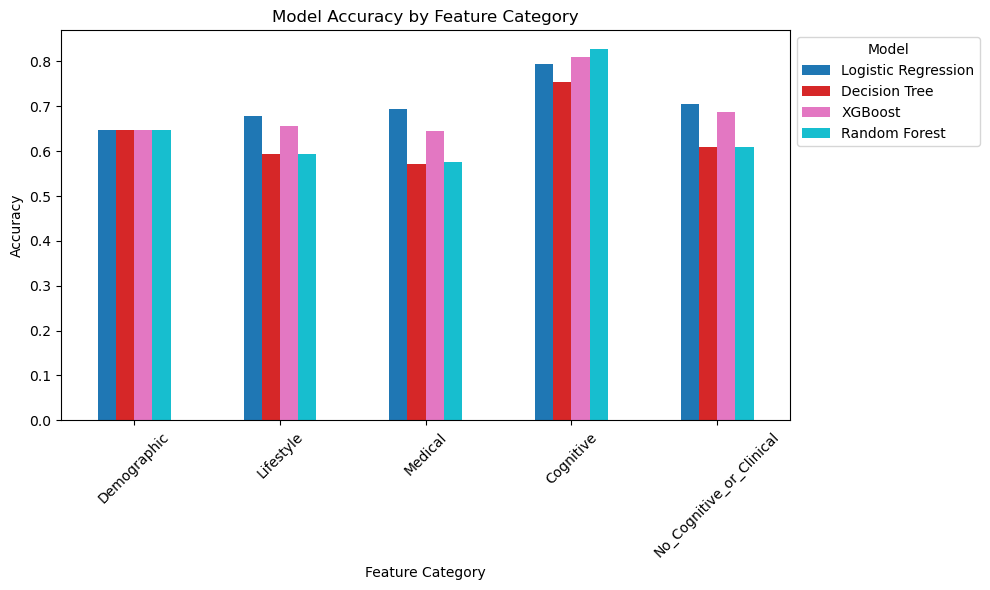

In [40]:
import pandas as pd

# converting results to a DataFrame for easy visualization
# .T - # Transpose for better readability
results_df = pd.DataFrame(results_by_category).T  
print(results_df)

# bar chart
results_df.plot(kind='bar', figsize=(10, 6), colormap='tab10')
plt.title("Model Accuracy by Feature Category")
plt.ylabel("Accuracy")
plt.xlabel("Feature Category")
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()  
plt.show()

Accuracy DataFrame:
                           Logistic Regression  Elastic Net  Random Forest  \
Demographic                          0.646512     0.646512       0.646512   
Lifestyle                            0.679070     0.679070       0.672093   
Medical                              0.693023     0.693023       0.648837   
Cognitive                            0.795349     0.795349       0.837209   
No_Cognitive_or_Clinical             0.704651     0.704651       0.669767   

                           XGBoost  
Demographic               0.646512  
Lifestyle                 0.676744  
Medical                   0.665116  
Cognitive                 0.837209  
No_Cognitive_or_Clinical  0.711628  


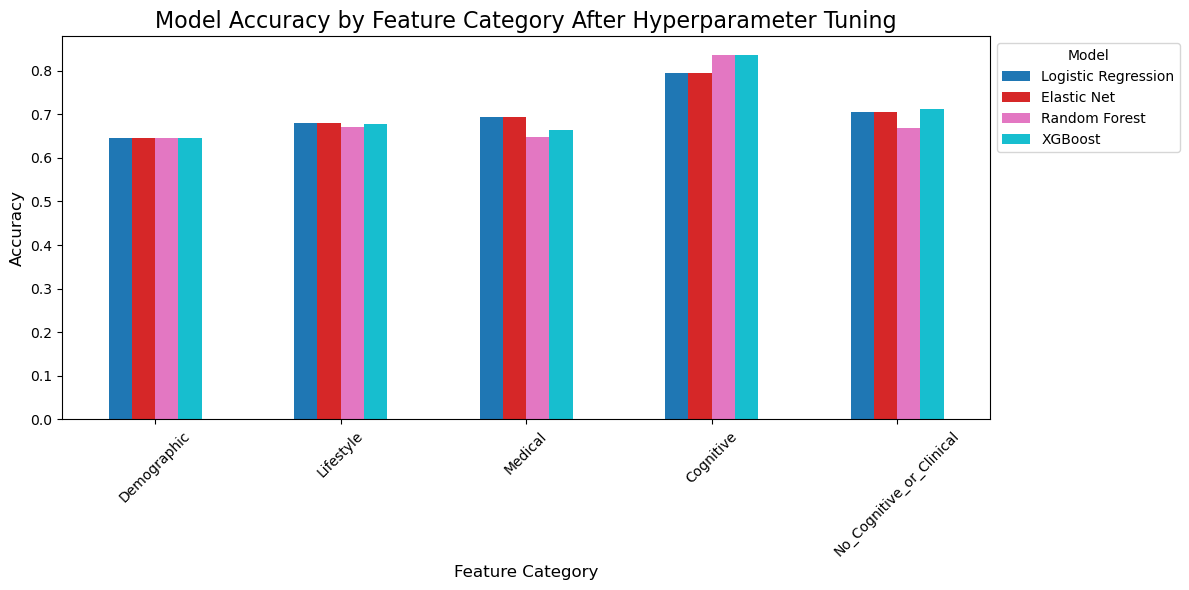

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract accuracy values into a DataFrame
results_df_tuning = pd.DataFrame({
    category: {model: metrics['accuracy'] for model, metrics in result.items()}
    for category, result in results_by_category_tuning.items()
}).T  # Transpose for better readability

# Display the DataFrame
print("Accuracy DataFrame:\n", results_df_tuning)

# Plot the accuracies as a bar chart
results_df_tuning.plot(kind='bar', figsize=(12, 6), colormap='tab10')
plt.title("Model Accuracy by Feature Category After Hyperparameter Tuning", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.savefig("model_accuracy_hyperparameter_tuning.jpg")
plt.show()


MOVE the following visualization above modelling

In [34]:
# Check the coefficients of the logistic regression model
model
important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]



[(np.float64(-0.9141530243688613), 'Gender'),
 (np.float64(-0.8807369816215513), 'Ethnicity'),
 (np.float64(-0.61775062779071), 'Age')]

In [35]:
# Check the feature importance of the decision tree model

important_feat = sorted(zip(
    models['Decision Tree'].feature_importances_,
    X.columns
), reverse=True)
important_feat[:7]

[(np.float64(0.35981948465356867), 'Age'),
 (np.float64(0.3330259214896157), 'Gender'),
 (np.float64(0.3071545938568156), 'Ethnicity')]

In [36]:
# Here is a problem.
# We know the five most important variables now, but we cannot compare within them since the models don't agree to each other.
# Regardless of this, I chose to stick with logistic regression. Here are the results:
# For Male, Asian, and Other Ethnicity, Functional Assessment is recommended;
# For Female, Caucasian, and African American, ADL is recommended.
# Now you might guess Functional Assessment will be recommended for Asian Male, but indeed the most significant factor is MemoryComplaints.
# Yeah.

In [37]:
Group = scaled_df[(scaled_df['Gender']==0) & (scaled_df['Ethnicity']==2)]  # You can play around with this
X = Group.drop(columns=['Diagnosis'])  # Predictors
y = Group['Diagnosis']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),  # Scaling is important for LR
        ('model', LogisticRegression())
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate each model
results = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)  # Train the model
    y_pred = pipeline.predict(X_test)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[model_name] = accuracy

# Check the coefficients of the logistic regression model

important_feat = sorted(zip(
    models['Logistic Regression'].named_steps['model'].coef_[0],
    X.columns
), key=lambda t: abs(t[0]), reverse=True)
important_feat[:7]

[(np.float64(1.6012063246493469), 'MemoryComplaints'),
 (np.float64(-1.363733977622461), 'FunctionalAssessment'),
 (np.float64(-0.7768694707206666), 'ADL'),
 (np.float64(-0.7456878138806804), 'MMSE'),
 (np.float64(-0.6935449700651924), 'Confusion'),
 (np.float64(0.639656907669354), 'DietQuality'),
 (np.float64(0.6023347111549886), 'Disorientation')]